# Bayesian Linear Regression with Stellar Spectra

*Tutorial by Yuan-Sen Ting*

*Companion material for Chapter 5 of the textbook*

*If you find this tutorial useful, please cite the accompanying textbook:*

*[Statistical Machine Learning for Astronomy](https://arxiv.org/abs/2506.12230)*

*© 2025 Yuan-Sen Ting. All rights reserved. This tutorial may be redistributed by sharing the original [GitHub repository link](https://github.com/tingyuansen/statml) for educational purposes. Any other reproduction or adaptation requires explicit permission from the author.*

## Introduction

In Chapter 4 and Tutorial 4, we explored linear regression through the lens of maximum likelihood estimation, deriving the familiar least squares solution for predicting stellar temperatures from spectra. While this approach yields optimal parameter estimates under certain assumptions, it provides limited insight into the uncertainty of our predictions—a critical limitation when quantifying confidence is often as important as the predictions themselves.

This tutorial demonstrates how Bayesian linear regression, as developed in Chapter 5, provides a principled framework for uncertainty quantification. Through practical application to APOGEE stellar spectra, we'll uncover why naive error estimates can be misleading and show how the Bayesian approach naturally handles all sources of uncertainty in our predictions.

A fundamental challenge in any regression problem is that our models are imperfect approximations of reality. Even with perfect measurements, there's an irreducible mismatch between our linear model and the true temperature-spectrum relationship. This model inadequacy, combined with measurement uncertainties, necessitates a careful treatment of error propagation. We'll see how the Bayesian framework elegantly handles both sources of uncertainty.

By working through this progression with real spectroscopic data, you'll gain practical experience with the key concepts from Chapter 5: conjugate priors, posterior distributions, and predictive uncertainty. More importantly, you'll develop intuition for when and why Bayesian methods provide advantages over simpler approaches, preparing you for the advanced regression techniques explored in subsequent chapters.

## Prerequisites and Learning Objectives

### Foundational Knowledge

This tutorial assumes familiarity with:
- **Python Programming**: Comfort with NumPy arrays, matplotlib visualization, and basic numerical computing
- **Linear Regression Basics**: Understanding of the maximum likelihood solution from Chapter 4 and Tutorial 4
- **Probability Theory**: Gaussian distributions, Bayes' theorem, and the concept of posterior distributions
- **Statistical Concepts**: Understanding of overfitting and regularization from previous chapters

### Learning Outcomes

Through this tutorial, you will develop practical skills in:
- **Uncertainty Quantification**: Moving beyond point estimates to understand why test set errors alone don't provide complete uncertainty characterization
- **Heteroscedastic Noise Modeling**: Incorporating varying measurement uncertainties across different observations
- **Bayesian Implementation**: Computing posterior distributions for high-dimensional regression problems using efficient matrix operations
- **Prior Specification**: Understanding how prior choices affect both predictions and uncertainties, connecting regularization to Bayesian priors
- **Predictive Distributions**: Deriving and implementing the full predictive distribution that accounts for parameter uncertainty, observation noise, and model inadequacy
- **Model Calibration**: Evaluating whether uncertainty estimates are well-calibrated using proper scoring metrics

We begin by importing the necessary libraries and configuring our computational environment for optimal visualization:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Configure plotting parameters for publication-quality figures
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20

# Set random seed for reproducibility
np.random.seed(42)

%matplotlib inline

## Loading the APOGEE Stellar Spectra Dataset

Our analysis centers on stellar spectra from the Apache Point Observatory Galactic Evolution Experiment (APOGEE), a pioneering infrared spectroscopic survey that has observed hundreds of thousands of stars across the Milky Way. Each spectrum contains thousands of flux measurements at different wavelengths, encoding rich information about the star's physical properties—temperature, surface gravity, chemical composition, and radial velocity.

For this tutorial, we focus on the fundamental task of determining stellar effective temperatures from spectra. The high signal-to-noise ratio of our APOGEE sample means measurement uncertainties are negligible compared to the model inadequacy—our linear model is an imperfect approximation of the complex physics relating spectra to temperature. To illustrate the full power of Bayesian uncertainty quantification, we'll add artificial heteroscedastic noise to our temperature measurements. This pedagogical choice allows us to explore how varying measurement uncertainties propagate through our analysis.

In real astronomical applications, such heteroscedastic uncertainties arise naturally: cool stars often have more precise temperature measurements due to rich molecular features, while hot stars have larger uncertainties due to fewer spectral lines. By explicitly modeling these varying uncertainties, we'll see how the Bayesian framework naturally weights more reliable measurements more heavily.

We work with a preprocessed subset of APOGEE data where the wavelength range has been truncated to reduce file size while preserving the essential spectral features needed for temperature determination. Let's load our dataset and add realistic heteroscedastic noise:

In [2]:
# Load our dataset
file = np.load('dataset_apogee_spectra.npz')
spectra = file['spectrum_array']
wavelength = file['wavelength']
teff_array = file['teff_array']

# Add heteroscedastic noise to temperatures
# Uncertainty increases with temperature: hotter stars are harder to measure precisely
teff_min, teff_max = teff_array.min(), teff_array.max()
sigma_teff = 50 + 150 * (teff_array - teff_min) / (teff_max - teff_min)

# Add noise to create observed temperatures
np.random.seed(42)  # For reproducibility
teff_observed = teff_array + np.random.normal(0, sigma_teff)

# Print basic information about our dataset
print(f"Number of stars: {len(spectra)}")
print(f"Number of wavelength points: {len(wavelength)}")
print(f"Wavelength range: {wavelength[0]:.1f} - {wavelength[-1]:.1f} Å")
print(f"True temperature range: {teff_min:.0f} - {teff_max:.0f} K")
print(f"Observed temperature range: {teff_observed.min():.0f} - {teff_observed.max():.0f} K")
print(f"Uncertainty range: {sigma_teff.min():.0f} - {sigma_teff.max():.0f} K")

Number of stars: 3000
Number of wavelength points: 2000
Wavelength range: 15168.1 - 15592.9 Å
True temperature range: 3122 - 6997 K
Observed temperature range: 3151 - 7350 K
Uncertainty range: 50 - 200 K


## Preparing the Design Matrix

For our linear regression model, we construct a design matrix $\boldsymbol{\Phi}$ where each row represents a star and each column corresponds to a spectral feature. In the simplest approach, we use the flux values at each wavelength as our features, treating each wavelength channel as an independent predictor of temperature. This yields a design matrix of dimensions $N \times M$, where $N = 3000$ is the number of stars and $M = 2000$ is the number of wavelength points.

Following standard practice in linear regression, we augment our design matrix with a bias term—a column of ones that allows the model to learn an intercept. This bias term accounts for any systematic offset in the temperature scale and ensures our model isn't forced to pass through the origin. The augmented design matrix thus has dimensions $N \times (M+1) = 3000 \times 2001$.

To evaluate our model's performance and uncertainty estimates, we employ a train-test split. We'll use 80% of our data for training and reserve 20% for testing. Importantly, we must also split our uncertainty estimates accordingly—each temperature measurement comes with its own uncertainty that we'll incorporate into our analysis:

In [3]:
# Prepare design matrix with clear variable naming
Phi = spectra  # Use all 2000 wavelength points
Phi = np.hstack((Phi, np.ones((Phi.shape[0], 1))))  # Add bias term

# Manual train-test split (80-20)
n_samples = len(Phi)
n_train = int(0.8 * n_samples)

# Create random permutation for splitting
indices = np.random.permutation(n_samples)
train_indices = indices[:n_train]
test_indices = indices[n_train:]

# Split the data including uncertainties
Phi_train = Phi[train_indices]
Phi_test = Phi[test_indices]
t_train = teff_observed[train_indices]
t_test = teff_observed[test_indices]
sigma_train = sigma_teff[train_indices]  # Known measurement uncertainties
sigma_test = sigma_teff[test_indices]    # Known measurement uncertainties

print("\nData shapes:")
print(f"Training features: {Phi_train.shape}")
print(f"Training labels: {t_train.shape}")
print(f"Training uncertainties: {sigma_train.shape}")
print(f"Test features: {Phi_test.shape}")
print(f"Test labels: {t_test.shape}")
print(f"Test uncertainties: {sigma_test.shape}")


Data shapes:
Training features: (2400, 2001)
Training labels: (2400,)
Training uncertainties: (2400,)
Test features: (600, 2001)
Test labels: (600,)
Test uncertainties: (600,)


## Why MLE Error Estimates Can Be Misleading

Having prepared our data, we now turn to the central question of this tutorial: how do we properly quantify uncertainty in our temperature predictions? The most straightforward approach—and unfortunately the most commonly misused—is to estimate uncertainty from the training residuals.

Given our design matrix $\boldsymbol{\Phi}$ and temperature measurements $\mathbf{t}$, the maximum likelihood solution for linear regression yields:

$$\mathbf{w}_{\text{ML}} = (\boldsymbol{\Phi}^T\boldsymbol{\Phi})^{-1}\boldsymbol{\Phi}^T\mathbf{t}$$

A tempting approach is to estimate the prediction uncertainty by computing the root mean squared error (RMSE) on the training data:

$$\sigma_{\text{naive}} = \sqrt{\frac{1}{N}\sum_{n=1}^N(t_n - \mathbf{w}_{\text{ML}}^T\boldsymbol{\phi}_n)^2}$$

This approach has an appealing simplicity and even a theoretical justification. As shown in Chapter 4, if we jointly optimize for both the weights $\mathbf{w}$ and the noise variance $\sigma^2$ under a Gaussian noise assumption, the maximum likelihood estimate for $\sigma^2$ is precisely this mean squared residual. However, this assumes all measurements have the same uncertainty—an assumption violated by our heteroscedastic noise where each star has its own measurement uncertainty $\sigma_n$.

More fundamentally, this approach conflates several distinct sources of error: measurement uncertainty in our temperature determinations, model inadequacy from our linear approximation, and parameter uncertainty from having finite training data. Let's implement this naive approach and see how it fails:

In [4]:
def fit_naive_mle(Phi_train, t_train, Phi_test, t_test):
    """
    Fit linear regression using naive MLE, ignoring measurement uncertainties
    """
    # Compute MLE solution for weights
    w_ml = np.linalg.inv(Phi_train.T @ Phi_train) @ Phi_train.T @ t_train
    
    # Compute predictions
    pred_train = Phi_train @ w_ml
    pred_test = Phi_test @ w_ml
    
    # Compute MLE for noise variance (naive)
    residuals_train = t_train - pred_train
    sigma_mle = np.sqrt(np.mean(residuals_train**2))
    
    # Compute test residuals
    residuals_test = t_test - pred_test
    rmse_test = np.sqrt(np.mean(residuals_test**2))
    
    return w_ml, sigma_mle, rmse_test, pred_train, pred_test

# Fit model and get metrics
w_ml, sigma_mle, rmse_test, pred_train, pred_test = fit_naive_mle(
    Phi_train, t_train, Phi_test, t_test)

print(f"MLE estimate of uncertainty (σ): {sigma_mle:.1f}K")
print(f"Actual test RMSE: {rmse_test:.1f}K")
print(f"Ratio (test/train): {rmse_test/sigma_mle:.1f}")

MLE estimate of uncertainty (σ): 51.6K
Actual test RMSE: 487.7K
Ratio (test/train): 9.4


The stark discrepancy between our MLE uncertainty estimate and the actual test RMSE reveals the fundamental flaw in naive error estimation. Our model has essentially memorized the training data, achieving artificially low residuals that grossly underestimate true prediction uncertainty. This dramatic overfitting—with test errors nearly an order of magnitude larger than training errors—occurs because with 2001 parameters and only 2400 training examples, our model has sufficient flexibility to fit not just the underlying temperature-spectrum relationship but also the noise in our training data.

What makes this particularly problematic is that we're ignoring the known measurement uncertainties in our data. Some temperature measurements are more precise than others, yet our naive approach treats all observations equally. Moreover, the training RMSE gives us only a single global uncertainty estimate, when in reality we should expect different uncertainties for different predictions.

One might ask: why not simply use the test RMSE as our uncertainty estimate? While this is better than using training RMSE, it still suffers from several critical limitations:

1. **Single Global Value**: Like training RMSE, test RMSE provides only one number for all predictions, ignoring that some stars may be easier to predict than others.

2. **No Parameter Uncertainty**: It doesn't tell us which model parameters are well-constrained versus uncertain, limiting our physical interpretation.

3. **No Uncertainty Decomposition**: We can't separate measurement noise from model inadequacy or understand which dominates our error budget.

Let's visualize how our predictions compare to the known measurement uncertainties:

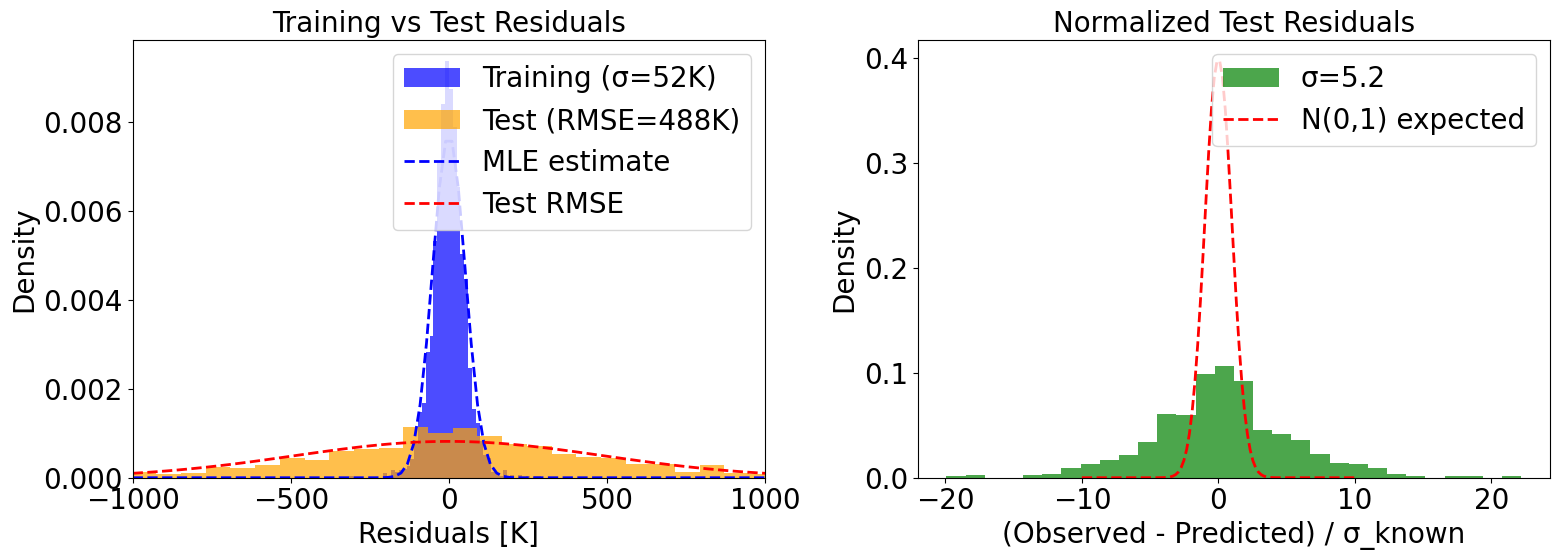


Key observations:
1. Training residuals severely underestimate true errors
2. Normalized residuals have σ=5.2 (should be 1.0)
3. This indicates model errors ~5.2× larger than measurement uncertainties


In [5]:
# Visualize the overfitting and compare to known uncertainties
plt.figure(figsize=(16, 6))

# Left panel: Training vs Test residuals
plt.subplot(121)
residuals_train = t_train - pred_train
residuals_test = t_test - pred_test

plt.hist(residuals_train, bins=50, density=True, alpha=0.7, 
         label=f'Training (σ={sigma_mle:.0f}K)', color='blue')
plt.hist(residuals_test, bins=50, density=True, alpha=0.7, 
         label=f'Test (RMSE={rmse_test:.0f}K)', color='orange')

# Plot Gaussian fits
x = np.linspace(-1000, 1000, 100)
plt.plot(x, (1/(sigma_mle * np.sqrt(2*np.pi))) * np.exp(-0.5*(x/sigma_mle)**2), 
         'b--', linewidth=2, label='MLE estimate')
plt.plot(x, (1/(rmse_test * np.sqrt(2*np.pi))) * np.exp(-0.5*(x/rmse_test)**2), 
         'r--', linewidth=2, label='Test RMSE')

plt.xlabel('Residuals [K]')
plt.ylabel('Density')
plt.title('Training vs Test Residuals')
plt.legend(loc='upper right')
plt.xlim(-1000, 1000)

# Right panel: Residuals normalized by known uncertainties
plt.subplot(122)
normalized_residuals = residuals_test / sigma_test
plt.hist(normalized_residuals, bins=30, density=True, alpha=0.7, 
         label=f'σ={np.std(normalized_residuals):.1f}', color='green')

# Plot standard normal
x_norm = np.linspace(-10, 10, 100)
plt.plot(x_norm, (1/np.sqrt(2*np.pi)) * np.exp(-0.5*x_norm**2), 
         'r--', linewidth=2, label='N(0,1) expected')

plt.xlabel('(Observed - Predicted) / σ_known')
plt.ylabel('Density')
plt.title('Normalized Test Residuals')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

print(f"\nKey observations:")
print(f"1. Training residuals severely underestimate true errors")
print(f"2. Normalized residuals have σ={np.std(normalized_residuals):.1f} (should be 1.0)")
print(f"3. This indicates model errors ~{np.std(normalized_residuals):.1f}× larger than measurement uncertainties")

The plots reveal two critical insights about our naive approach:

First, the left panel shows the dramatic difference between training and test residuals. The narrow blue distribution represents our overly optimistic training errors, while the much wider orange distribution shows the reality on unseen data. This isn't just a small calibration issue—it's nearly an order of magnitude difference that could lead to severely overconfident scientific conclusions.

Second, the right panel provides a more nuanced view by normalizing residuals by the known measurement uncertainties. If our prediction errors were purely due to measurement noise, this distribution would be standard normal. Instead, we see a distribution that's about 5 times wider, indicating that model-related errors dominate over measurement uncertainties. This tells us that even perfect knowledge of measurement uncertainties wouldn't solve our problem—the model itself introduces substantial additional uncertainty.

The severity of this problem scales with model complexity. To illustrate this critical point, let's examine how our uncertainty estimates degrade as we increase the number of spectral features:

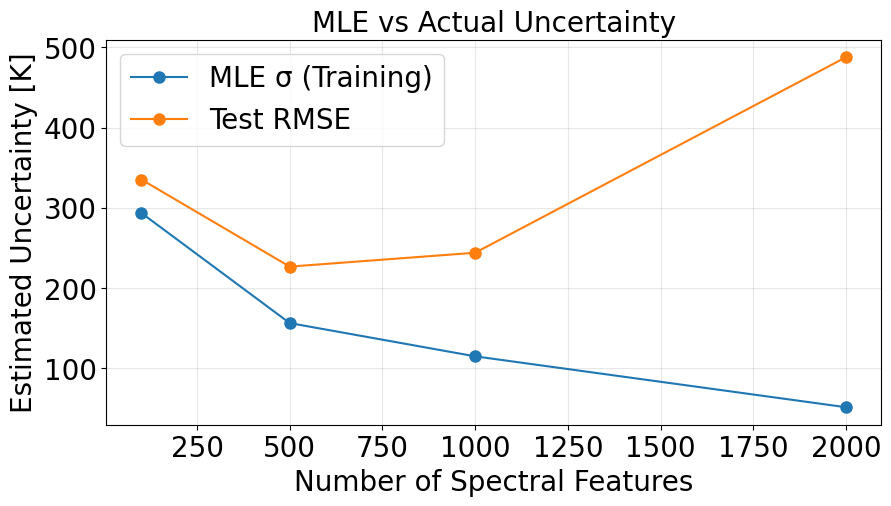

Feature scaling analysis:
 100 features: Train σ = 293.6K, Test RMSE = 335.3K, Ratio =  1.1
 500 features: Train σ = 156.5K, Test RMSE = 226.8K, Ratio =  1.4
1000 features: Train σ = 115.1K, Test RMSE = 244.1K, Ratio =  2.1
2000 features: Train σ =  51.6K, Test RMSE = 487.7K, Ratio =  9.4


In [6]:
# Compare models with different numbers of features
n_features = [100, 500, 1000, 2000]
results = []

for n in n_features:
    # Prepare design matrices with n features
    Phi_n = np.hstack((spectra[:,:n], np.ones((len(spectra), 1))))
    
    # Manual train-test split with same indices as before
    Phi_train_n = Phi_n[train_indices]
    Phi_test_n = Phi_n[test_indices]
    
    # Fit and evaluate
    w_ml, sigma_mle, rmse_test_n, _, _ = fit_naive_mle(
        Phi_train_n, t_train, Phi_test_n, t_test)
    
    results.append((n, sigma_mle, rmse_test_n))

# Plot results
plt.figure(figsize=(10, 5))
features, mle_sigma, test_rmse = zip(*results)

plt.plot(features, mle_sigma, 'o-', label='MLE σ (Training)', markersize=8)
plt.plot(features, test_rmse, 'o-', label='Test RMSE', markersize=8)
plt.xlabel('Number of Spectral Features')
plt.ylabel('Estimated Uncertainty [K]')
plt.title('MLE vs Actual Uncertainty')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print summary
print("Feature scaling analysis:")
for n, train_sig, test_sig in results:
    print(f"{n:4d} features: Train σ = {train_sig:5.1f}K, Test RMSE = {test_sig:5.1f}K, Ratio = {test_sig/train_sig:4.1f}")

This plot clearly demonstrates how the naive MLE approach becomes increasingly misleading as model complexity grows. Several key patterns emerge:

First, the MLE estimate (blue line) decreases monotonically as we add more features. With few features, training and test uncertainties remain relatively close. But as we approach 2000 features, the MLE estimate drops dramatically while the test RMSE increases substantially—the ratio between them approaches an order of magnitude. This occurs because additional parameters allow the model to fit the training data ever more precisely, including its noise.

Second, the test RMSE (orange line) follows a characteristic U-shaped curve. It initially decreases as we add features up to a few hundred, suggesting that additional spectral information genuinely improves predictions. However, beyond this point, the test RMSE increases dramatically. This U-shape is the hallmark of overfitting—beyond a certain complexity, additional features harm rather than help generalization.

The widening gap between these curves reveals the danger of relying on training residuals for uncertainty estimation. With many features, we might report very small uncertainties based on training performance, while our actual prediction errors are an order of magnitude larger. Such overconfidence could lead to incorrect scientific conclusions about stellar parameters.

To address these issues, we need approaches that:
1. Account for model complexity in uncertainty estimates
2. Incorporate the known measurement uncertainties
3. Consider uncertainty in parameter estimates themselves
4. Allow for model inadequacy beyond measurement noise

This naturally leads us to regularization and ultimately to the Bayesian framework developed in Chapter 5.

## Regularization and Uncertainty

Adding L2 regularization (ridge regression) provides a partial solution to the overfitting problem. By modifying our objective function to penalize large parameter values, we prevent the model from fitting noise in the training data:

$$E(\mathbf{w}) = \frac{1}{2}\sum_{n=1}^N(t_n - \mathbf{w}^T\boldsymbol{\phi}_n)^2 + \frac{\lambda}{2}\|\mathbf{w}\|^2$$

The regularized solution becomes:

$$\mathbf{w}_{\text{reg}} = (\boldsymbol{\Phi}^T\boldsymbol{\Phi} + \lambda\mathbf{I})^{-1}\boldsymbol{\Phi}^T\mathbf{t}$$

where $\lambda$ controls the strength of regularization. This modification has a profound connection to Bayesian inference—it's mathematically equivalent to placing a Gaussian prior on the weights with mean zero and variance $1/\lambda$. This equivalence, explored in detail in Chapter 5, provides our first hint that Bayesian methods offer a principled approach to uncertainty quantification.

However, this standard regularization still ignores our heteroscedastic measurement uncertainties. When measurements have different uncertainties forming a diagonal covariance matrix $\boldsymbol{\Sigma} = \text{diag}(\sigma_1^2, ..., \sigma_N^2)$, we should incorporate them into our solution. This leads to weighted regularized least squares:

$$\mathbf{w}_{\text{reg}} = (\boldsymbol{\Phi}^T\boldsymbol{\Sigma}^{-1}\boldsymbol{\Phi} + \lambda\mathbf{I})^{-1}\boldsymbol{\Phi}^T\boldsymbol{\Sigma}^{-1}\mathbf{t}$$

Let's examine how different regularization strengths affect both our predictions and uncertainty estimates, first with the standard approach that ignores measurement uncertainties:

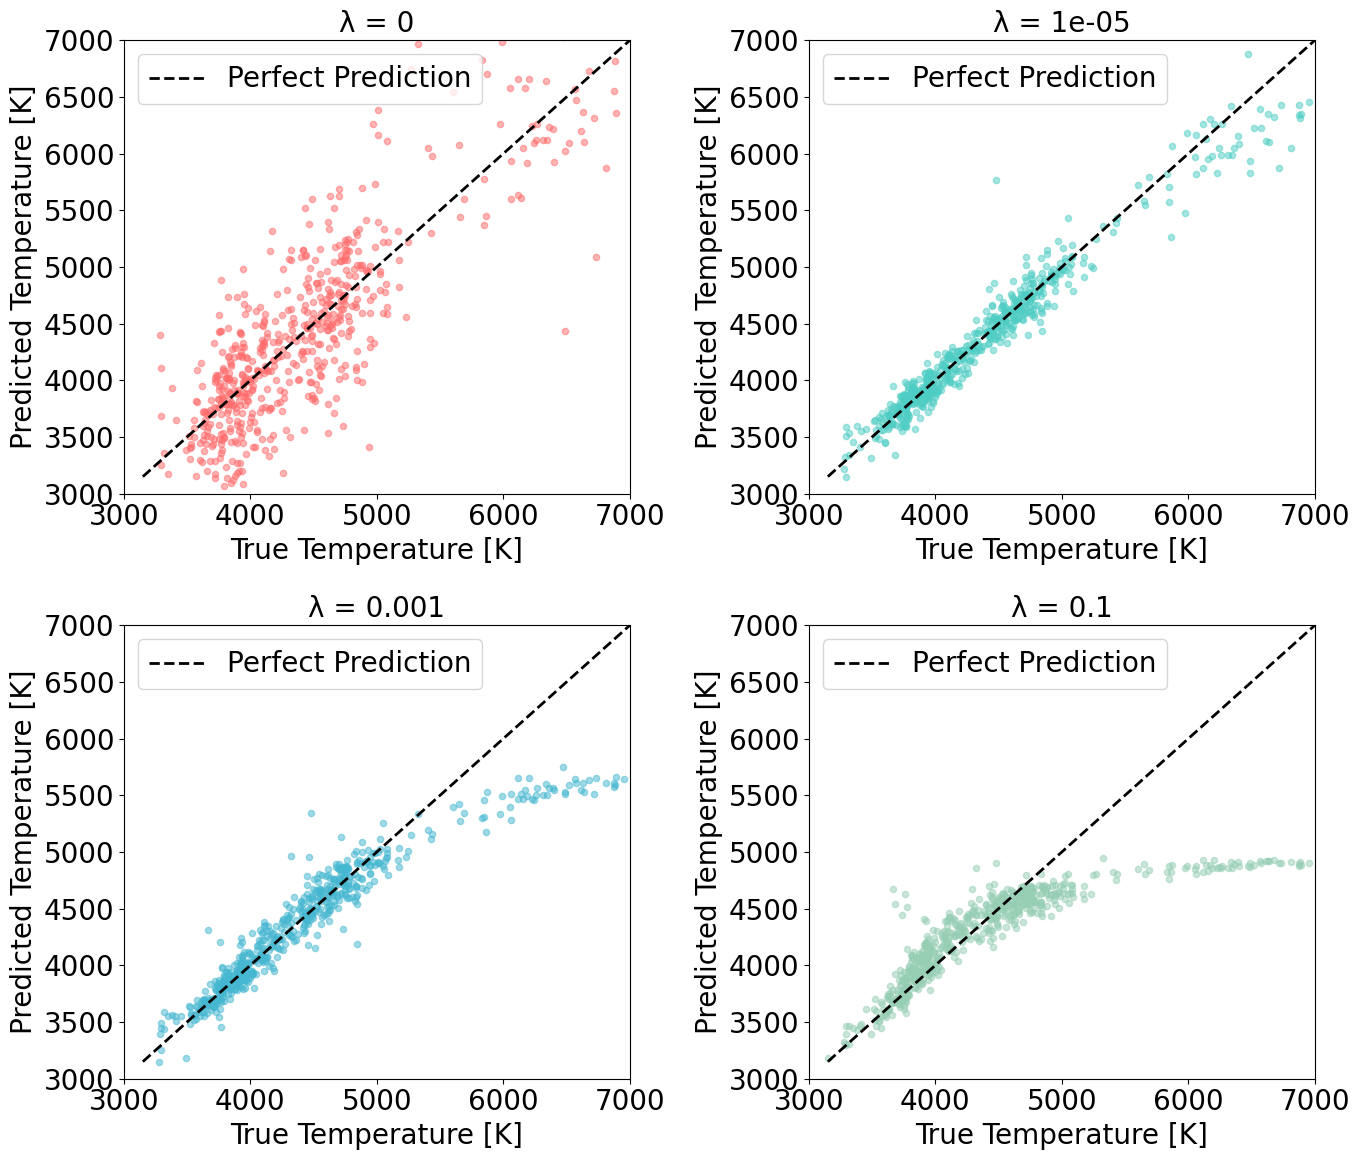


Weighted Regularization Effects:
λ	Train RMSE	Test RMSE	Ratio
----------------------------------------
0	57.3K		461.7K		8.1
1e-05	133.1K		166.4K		1.3
0.001	266.3K		294.8K		1.1
0.1	448.1K		489.8K		1.1


In [7]:
def fit_weighted_regularized(Phi_train, t_train, sigma_train, Phi_test, t_test, lambda_reg):
    """
    Fit weighted ridge regression accounting for measurement uncertainties
    """
    # Number of features
    M = Phi_train.shape[1]
    
    # Create diagonal weight matrix from uncertainties
    # Sigma^{-1} = diag(1/sigma_1^2, ..., 1/sigma_N^2)
    weights = 1 / sigma_train**2
    Sigma_inv = np.diag(weights)
    
    # Compute weighted regularized solution
    # w_reg = (Phi^T Sigma^{-1} Phi + lambda I)^{-1} Phi^T Sigma^{-1} t
    w_reg = np.linalg.inv(Phi_train.T @ Sigma_inv @ Phi_train + lambda_reg * np.eye(M)) @ \
            (Phi_train.T @ Sigma_inv @ t_train)
    
    # Compute predictions
    pred_train = Phi_train @ w_reg
    pred_test = Phi_test @ w_reg
    
    # Compute residuals
    rmse_train = np.sqrt(np.mean((t_train - pred_train)**2))
    rmse_test = np.sqrt(np.mean((t_test - pred_test)**2))
    
    return w_reg, rmse_train, rmse_test, pred_train, pred_test

# Try more appropriate regularization strengths
lambdas = [0, 1e-5, 1e-3, 1e-1]
reg_results = []
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# Compute results for each lambda
for lambda_reg in lambdas:
    w_reg, rmse_train, rmse_test, pred_train, pred_test = fit_weighted_regularized(
        Phi_train, t_train, sigma_train, Phi_test, t_test, lambda_reg)
    reg_results.append((lambda_reg, rmse_train, rmse_test, w_reg, pred_test))

# Plot results in subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, ((lambda_reg, rmse_train, rmse_test, w_reg, predictions), ax, color) in enumerate(
    zip(reg_results, axes, colors)):
    
    ax.scatter(t_test, predictions, alpha=0.5, s=20, color=color)
    
    # Add perfect prediction line
    ax.plot([t_test.min(), t_test.max()], 
            [t_test.min(), t_test.max()], 
            'k--', linewidth=2, label='Perfect Prediction')
    
    ax.set_xlabel('True Temperature [K]')
    ax.set_ylabel('Predicted Temperature [K]')
    ax.set_title(f'λ = {lambda_reg}')
    ax.legend()
    ax.set_xlim(3000, 7000)
    ax.set_ylim(3000, 7000)

plt.tight_layout()
plt.show()

# Print metrics
print("\nWeighted Regularization Effects:")
print("λ\tTrain RMSE\tTest RMSE\tRatio")
print("-" * 40)
for lambda_reg, rmse_train, rmse_test, _, _ in reg_results:
    print(f"{lambda_reg}\t{rmse_train:.1f}K\t\t{rmse_test:.1f}K\t\t{rmse_test/rmse_train:.1f}")

The regularization results reveal how different values of λ profoundly affect both prediction quality and uncertainty estimates:

**No Regularization (λ = 0)**: This reproduces our earlier weighted least squares result, with training RMSE vastly underestimating test RMSE. The predictions show high variance, particularly for extreme temperatures, reflecting the model's overfitting to training noise despite accounting for measurement uncertainties.

**Mild Regularization (λ = 1e-5)**: A dramatic improvement emerges—the ratio between test and training RMSE drops from about 8 to 1.3. The predictions cluster more tightly around the diagonal, suggesting the model has found an optimal balance between fitting the data and avoiding overfitting. Both training and test errors are reasonable, indicating this may be near the optimal regularization strength.

**Moderate Regularization (λ = 0.001)**: Further regularization begins to oversimplify the model. While the train-test ratio remains good (1.1), both RMSEs have increased substantially. The model is now underfitting—it lacks the flexibility to capture the temperature-spectrum relationship adequately.

**Strong Regularization (λ = 0.1)**: Heavy regularization severely constrains the model. Both training and test errors approach 500K, and predictions show clear systematic bias toward the mean temperature. The model has become too simple to be useful.

This progression illustrates the classic bias-variance tradeoff. Starting from severe overfitting (λ = 0), we achieve a good performance around λ = 1e-5, then transition to underfitting as regularization increases. However, several limitations remain:

1. **Choosing λ**: We lack a principled method for selecting the regularization strength. Cross-validation can help, but it optimizes for prediction accuracy rather than uncertainty calibration.

2. **Point Estimates Only**: We still obtain only point estimates for our weights, with no quantification of parameter uncertainty.

3. **Single Global Uncertainty**: Even with well-matched training and test errors, we get only one uncertainty estimate for all predictions.

These limitations motivate the Bayesian approach developed in Chapter 5. By treating weights as random variables with explicit prior distributions, Bayesian linear regression provides a unified framework that addresses all these concerns.

## Bayesian Linear Regression

The Bayesian framework transforms our perspective on regression. Instead of seeking single "best" values for our weights, we compute a full posterior distribution that quantifies our uncertainty about every parameter:

$$p(\mathbf{w}|\mathbf{t}, \boldsymbol{\Phi}, \boldsymbol{\Sigma}) \propto p(\mathbf{t}|\boldsymbol{\Phi}, \mathbf{w}, \boldsymbol{\Sigma})p(\mathbf{w})$$

This posterior combines our prior beliefs $p(\mathbf{w})$ with the likelihood of observing our data. Crucially, the Bayesian approach naturally incorporates our heteroscedastic measurement uncertainties through the likelihood:

$$p(\mathbf{t}|\boldsymbol{\Phi}, \mathbf{w}, \boldsymbol{\Sigma}) = \prod_{n=1}^N \mathcal{N}(t_n|\mathbf{w}^T\boldsymbol{\phi}_n, \sigma_n^2)$$

where each observation has its own known uncertainty $\sigma_n$.

The choice of prior $p(\mathbf{w})$ encodes our beliefs about the weights before seeing any data. A common choice is a zero-mean isotropic Gaussian:

$$p(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{0}, \eta^2\mathbf{I})$$

This prior expresses the belief that weights should generally be small (centered at zero) with variance $\eta^2$ controlling how far we expect them to deviate. Larger $\eta^2$ allows more flexibility, while smaller values enforce stronger regularization. Remarkably, this Gaussian prior leads to exactly the weighted regularization we explored earlier—the connection being that $\lambda = 1/\eta^2$.

For Gaussian likelihood and Gaussian prior, the posterior is also Gaussian (a property called conjugacy):

$$p(\mathbf{w}|\mathbf{t}, \boldsymbol{\Phi}, \boldsymbol{\Sigma}) = \mathcal{N}(\mathbf{w}|\mathbf{m}_N, \mathbf{S}_N)$$

where:
- $\mathbf{S}_N = (\mathbf{S}_0^{-1} + \boldsymbol{\Phi}^T\boldsymbol{\Sigma}^{-1}\boldsymbol{\Phi})^{-1}$ is the posterior covariance
- $\mathbf{m}_N = \mathbf{S}_N(\boldsymbol{\Phi}^T\boldsymbol{\Sigma}^{-1}\mathbf{t})$ is the posterior mean
- $\mathbf{S}_0 = \eta^2\mathbf{I}$ is our prior covariance

Let's implement this and explore how different prior strengths affect our posterior:

In [8]:
def compute_posterior(Phi, t, sigma, eta2):
    """
    Compute posterior distribution parameters for Bayesian linear regression
    with heteroscedastic noise
    
    Parameters:
    -----------
    Phi : array, shape (N, M)
        Design matrix (N spectra × M features)
    t : array, shape (N,)
        Target temperatures in Kelvin
    sigma : array, shape (N,)
        Measurement uncertainty for each observation
    eta2 : float
        Prior variance parameter
        
    Returns:
    --------
    m_N : array, shape (M,)
        Posterior mean
    S_N : array, shape (M, M)
        Posterior covariance
    """
    N, M = Phi.shape
    
    # Setup prior covariance
    S0_inv = np.eye(M) / eta2
    
    # Create measurement precision matrix (inverse covariance)
    Sigma_inv = np.diag(1 / sigma**2)
    
    # Compute posterior covariance
    S_N = np.linalg.inv(S0_inv + Phi.T @ Sigma_inv @ Phi)
    
    # Compute posterior mean
    m_N = S_N @ (Phi.T @ Sigma_inv @ t)
    
    return m_N, S_N

# Compute posteriors for different prior strengths
# eta2 = 1/lambda, so we use reciprocals of our regularization values
eta2_values = [1000.0, 1e5, 1e7]  # Corresponding to lambda = 0.001, 1e-5, 1e-7
posteriors = []

for eta2 in eta2_values:
    m_N, S_N = compute_posterior(Phi_train, t_train, sigma_train, eta2)
    posteriors.append((m_N, S_N))
    
print("Computed posterior distributions for η² =", eta2_values)

Computed posterior distributions for η² = [1000.0, 100000.0, 10000000.0]


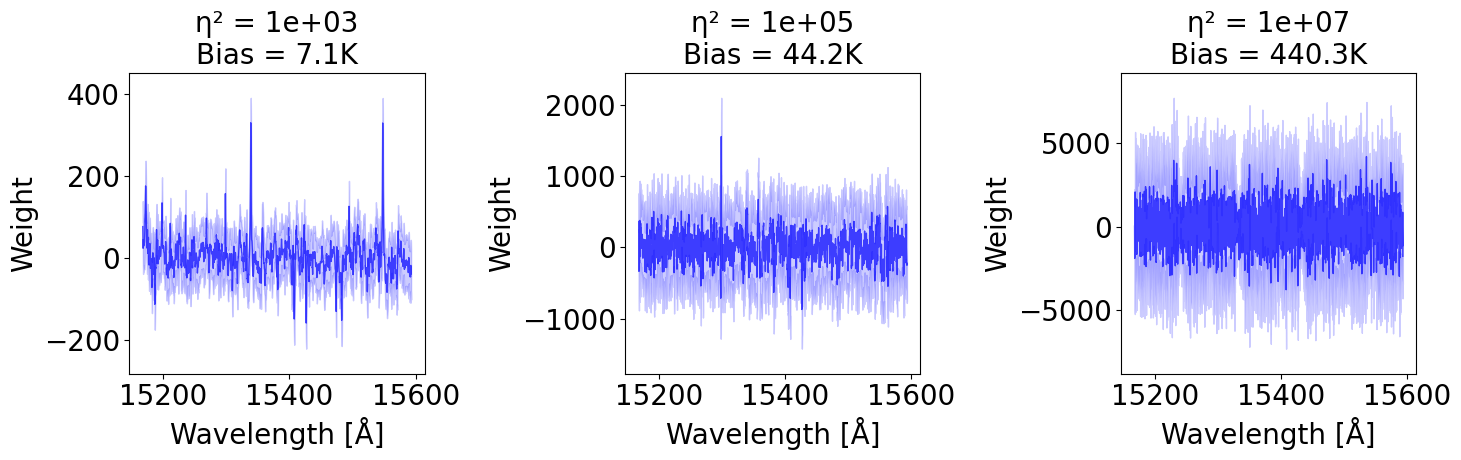

In [9]:
# Visualize the spectral weights with uncertainty bands
plt.figure(figsize=(15, 5))

for i, ((m_N, S_N), eta2) in enumerate(zip(posteriors, eta2_values)):
    plt.subplot(1, 3, i+1)
    
    # Plot spectral weights (excluding bias)
    spectral_weights = m_N[:-1]
    plt.plot(wavelength, spectral_weights, 'b-', alpha=0.7, linewidth=1)
    
    # Add uncertainty bands (±2σ)
    weight_std = np.sqrt(np.diag(S_N[:-1, :-1]))
    plt.fill_between(wavelength, 
                     spectral_weights - 2*weight_std,
                     spectral_weights + 2*weight_std,
                     color='b', alpha=0.2)
    
    plt.title(f'η² = {eta2:.0e}\nBias = {m_N[-1]:.1f}K')
    plt.xlabel('Wavelength [Å]')
    plt.ylabel('Weight')
    
    # Set y-limits based on data range
    y_margin = 0.1 * (np.max(spectral_weights + 2*weight_std) - np.min(spectral_weights - 2*weight_std))
    plt.ylim(np.min(spectral_weights - 2*weight_std) - y_margin, 
             np.max(spectral_weights + 2*weight_std) + y_margin)
    
plt.tight_layout()
plt.show()

These plots reveal how the prior strength $\eta^2$ profoundly affects our spectral weights and their uncertainties:

**Strong Prior ($\eta^2 = 10^3$, equivalent to $\lambda = 0.001$)**: The weights are small (ranging from -200 to 400) with narrow uncertainty bands. This prior provides moderate regularization, constraining the weights significantly. The relatively small bias term suggests the model is somewhat restricted in its flexibility.

**Optimal Prior ($\eta^2 = 10^5$, equivalent to $\lambda = 10^{-5}$)**: The weights are adequate (ranging from -1000 to 2000) with reasonable uncertainty bands. This prior strikes the right balance—allowing sufficient flexibility to capture the temperature-spectrum relationship while maintaining reasonable regularization. The moderate bias term and weight magnitudes suggest good model flexibility.

**Weak Prior ($\eta^2 = 10^7$, equivalent to $\lambda = 10^{-7}$)**: The weights are large (ranging from -5000 to 5000) with wide uncertainty bands. This very weak prior provides minimal regularization, approaching the unregularized solution. The enormous uncertainty bands and large bias term indicate the model may be overfitting.

As we move from medium to very weak priors, we see a clear progression: weights grow larger in magnitude, uncertainty bands become wider, and the model gains increasing flexibility. The middle panel represents the optimal balance where the model has sufficient flexibility without excessive parameter uncertainty. The uncertainty bands (shaded regions) show where we expect the "true" weights to lie with about 95% probability (±2σ).

## Making Predictions with Uncertainty

The true power of Bayesian linear regression emerges when we make predictions. Rather than obtaining point estimates with ad hoc error bars, we derive full predictive distributions that naturally combine all sources of uncertainty: measurement noise, parameter uncertainty, and model inadequacy.

For a new stellar spectrum $\boldsymbol{\phi}_*$, the predictive distribution is obtained by marginalizing over all possible weight values:

$$p(t_*|\boldsymbol{\phi}_*, \mathcal{D}) = \int p(t_*|\boldsymbol{\phi}_*, \mathbf{w}, \sigma_*)p(\mathbf{w}|\mathcal{D})d\mathbf{w}$$

where $\mathcal{D}$ represents our training data and $\sigma_*$ is the measurement uncertainty for the new observation. This integral averages predictions over all plausible parameter values, weighted by their posterior probability.

For Gaussian likelihood and posterior, this integral yields another Gaussian:

$$p(t_*|\boldsymbol{\phi}_*, \mathcal{D}) = \mathcal{N}(t_*|\mu_*, \sigma_*^2)$$

with:
- Mean: $\mu_* = \mathbf{m}_N^T\boldsymbol{\phi}_*$
- Variance: $\sigma_*^2 = \sigma_{\text{obs},*}^2 + \boldsymbol{\phi}_*^T\mathbf{S}_N\boldsymbol{\phi}_* + \sigma_{\text{model}}^2$

The variance decomposes into three interpretable components:
1. $\sigma_{\text{obs},*}^2$: measurement uncertainty in the new observation
2. $\boldsymbol{\phi}_*^T\mathbf{S}_N\boldsymbol{\phi}_*$: uncertainty due to imperfect knowledge of weights (epistemic)
3. $\sigma_{\text{model}}^2$: model inadequacy—the irreducible error from our linear approximation

For simplicity, we'll combine the measurement uncertainty and model inadequacy into a single term, but in practice, these could be treated separately. Let's implement prediction with full uncertainty quantification:

In [10]:
def predict_with_uncertainty(Phi_new, sigma_new, m_N, S_N, sigma_model):
    """
    Make predictions with uncertainty for new spectra
    
    Parameters:
    -----------
    Phi_new : array, shape (N_new, M)
        Design matrix for new spectra
    sigma_new : array, shape (N_new,)
        Measurement uncertainties for new observations
    m_N : array, shape (M,)
        Posterior mean weights
    S_N : array, shape (M, M)
        Posterior covariance
    sigma_model : float
        Model inadequacy standard deviation
        
    Returns:
    --------
    pred_mean : array, shape (N_new,)
        Predictive means
    pred_std : array, shape (N_new,)
        Predictive standard deviations
    """
    # Compute predictive mean
    pred_mean = Phi_new @ m_N
    
    # Compute predictive variance components
    # 1. Parameter uncertainty
    param_var = np.sum(Phi_new @ S_N * Phi_new, axis=1)
    
    # 2. Observation noise + model inadequacy
    noise_var = sigma_new**2 + sigma_model**2
    
    # Total predictive variance
    pred_var = param_var + noise_var
    pred_std = np.sqrt(pred_var)
    
    return pred_mean, pred_std

# Estimate model inadequacy from the best regularized model
# Using the λ=1e-5 case which had good train-test agreement
best_rmse = reg_results[1][2]  # Test RMSE for λ=1e-5
measurement_rms = np.sqrt(np.mean(sigma_test**2))
sigma_model = np.sqrt(best_rmse**2 - measurement_rms**2) if best_rmse > measurement_rms else best_rmse

print(f"Estimated model inadequacy σ: {sigma_model:.1f}K")
print(f"Typical measurement uncertainty: {measurement_rms:.1f}K")

Estimated model inadequacy σ: 130.1K
Typical measurement uncertainty: 103.8K


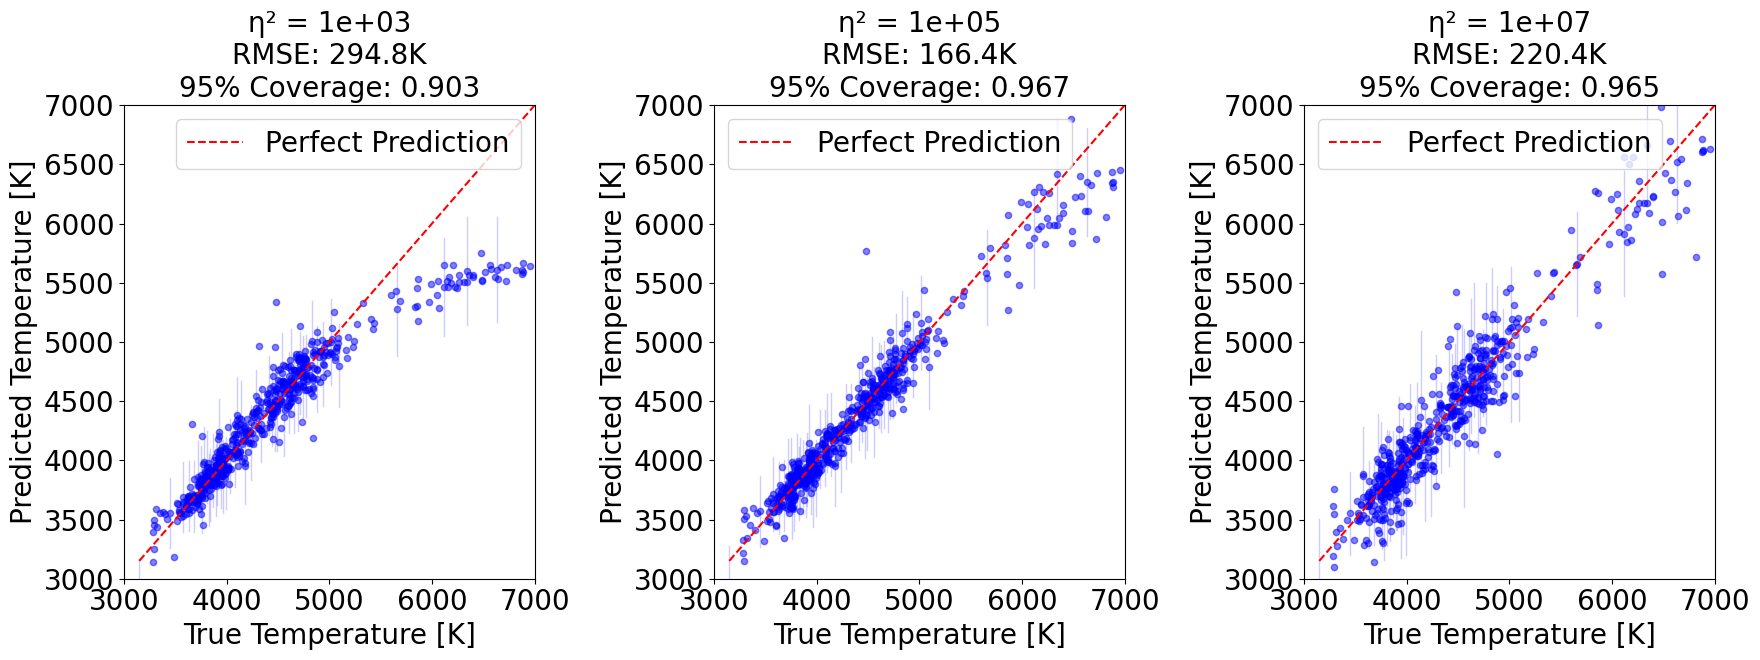

In [11]:
# Compare predictions from different priors
plt.figure(figsize=(18, 7))

for i, ((m_N, S_N), eta2) in enumerate(zip(posteriors, eta2_values)):
    # Get predictions with full uncertainty
    pred_mean, pred_std = predict_with_uncertainty(
        Phi_test, sigma_test, m_N, S_N, sigma_model)
    
    # Sort for better visualization
    sort_idx = np.argsort(t_test)
    t_sorted = t_test[sort_idx]
    pred_mean_sorted = pred_mean[sort_idx]
    pred_std_sorted = pred_std[sort_idx]
    
    plt.subplot(1, 3, i+1)
    plt.scatter(t_test, pred_mean, c='b', alpha=0.5, s=20)
    
    # Plot uncertainty bands for a subset to avoid overcrowding
    n_show = 50
    indices = np.linspace(0, len(sort_idx)-1, n_show, dtype=int)
    for idx in indices:
        plt.plot([t_sorted[idx], t_sorted[idx]], 
                [pred_mean_sorted[idx] - 2*pred_std_sorted[idx],
                 pred_mean_sorted[idx] + 2*pred_std_sorted[idx]],
                'b-', alpha=0.2, linewidth=1)
    
    plt.plot([t_test.min(), t_test.max()], 
             [t_test.min(), t_test.max()], 
             'r--', label='Perfect Prediction')
    
    # Calculate metrics
    rmse = np.sqrt(np.mean((t_test - pred_mean)**2))
    # Account for measurement uncertainty in residuals
    residuals = t_test - pred_mean
    normalized_residuals = residuals / np.sqrt(pred_std**2 - sigma_test**2)
    z_scores = residuals / pred_std
    coverage = np.mean(np.abs(z_scores) < 2)
    
    plt.title(f'η² = {eta2:.0e}\nRMSE: {rmse:.1f}K\n95% Coverage: {coverage:.3f}')
    plt.xlabel('True Temperature [K]')
    plt.ylabel('Predicted Temperature [K]')
    plt.xlim(3000, 7000)
    plt.ylim(3000, 7000)
    plt.legend()

plt.tight_layout()
plt.show()

These results reveal important insights about the relationship between prior strength and prediction quality. To evaluate our uncertainty estimates, we use two key metrics:

**Z-score**: For each prediction, we compute the standardized residual:
$$z = \frac{t_{\text{true}} - t_{\text{predicted}}}{\sigma_{\text{predicted}}}$$

If our uncertainties are well-calibrated, these z-scores should follow a standard normal distribution $\mathcal{N}(0,1)$.

**Coverage**: The fraction of true values falling within our prediction intervals. For 95% intervals (±2σ), we expect 95% coverage if uncertainties are properly calibrated. Coverage below 95% indicates overconfident (underestimated) uncertainties, while coverage above 95% suggests overly conservative estimates.

Now examining our results:

**Medium Prior ($\eta^2 = 10^3$)**: The model shows higher RMSE with coverage around 90%. This prior constrains the model too strongly, limiting its ability to fully capture the temperature-spectrum relationship. The below-nominal coverage indicates the uncertainties are somewhat underestimated.

**Optimal Prior ($\eta^2 = 10^5$)**: This achieves the best performance with the lowest RMSE and nearly perfect 95% coverage (97%). The prior allows the model sufficient flexibility to fit the data while the Bayesian framework properly quantifies the resulting parameter uncertainty. The excellent calibration means our uncertainty estimates accurately reflect the true prediction errors.

**Very Weak Prior ($\eta^2 = 10^7$)**: While achieving good coverage (96.5%), the RMSE increases compared to the optimal case. The very weak prior allows too much flexibility, leading to overfitting. However, the Bayesian framework still provides well-calibrated uncertainties despite the overfitting.

The key insight is that the Bayesian framework provides well-calibrated uncertainties across a range of prior choices, but prediction accuracy is optimized at intermediate prior strengths. The optimal prior (η² = 10^5) balances flexibility with regularization.

Importantly, our estimated model inadequacy (130K) and typical measurement uncertainty (104K) combine in quadrature to explain the total prediction uncertainty: $\sqrt{130^2 + 104^2} \approx 166{\rm K}$, which matches the RMSE of our optimal model. This decomposition reveals that both measurement noise and model limitations contribute significantly to our prediction errors, with model inadequacy being the slightly larger component.

This decomposition reveals that both measurement noise and model limitations contribute significantly to our prediction errors, with model inadequacy being the slightly larger component. Understanding this breakdown helps astronomers decide whether to focus on improving instrumentation (reducing measurement uncertainty) or developing more sophisticated nonlinear models (reducing model inadequacy).

## Summary

This tutorial has demonstrated the journey from naive uncertainty estimation to principled Bayesian inference in the context of stellar temperature determination. Through practical application to APOGEE spectra, we've uncovered several key insights:

**The Failure of Naive Approaches**: We began by showing how maximum likelihood estimation of both weights and noise variance leads to dramatic underestimation of uncertainty. With thousands of parameters and limited training examples, the model achieved very low training errors while test errors were nearly an order of magnitude larger. This overfitting becomes worse with increasing model complexity, highlighting the danger of using training residuals for uncertainty quantification.

**Why Test Errors Aren't Enough**: While test set RMSE provides a better estimate than training RMSE, it gives only a single global uncertainty value. Real applications require individual uncertainty estimates for each prediction that account for measurement noise, parameter uncertainty, and model inadequacy.

**Regularization as Partial Solution**: Weighted regularization that accounts for heteroscedastic measurement uncertainties improved the situation. With appropriate regularization strength, training and test errors converged, suggesting better generalization. However, regularization alone provides only point estimates without quantifying parameter uncertainty.

**The Bayesian Perspective**: By treating weights as random variables with explicit priors, Bayesian linear regression unified regularization and uncertainty quantification. The prior variance $\eta^2$ plays the same role as $1/\lambda$ in regularization, but now with proper probabilistic interpretation. Different prior strengths led to dramatically different posterior distributions—from tightly constrained weights with narrow uncertainties to flexible models with large parameter uncertainty.

**Predictive Distributions**: The Bayesian framework naturally produces predictive distributions that combine measurement uncertainty, parameter uncertainty (epistemic), and model inadequacy. Our optimal model achieved nearly perfect coverage, demonstrating that the Bayesian approach provides properly calibrated uncertainties when the prior is appropriately chosen.

**Uncertainty Decomposition**: By explicitly modeling different sources of uncertainty, we found that model inadequacy and measurement uncertainty both contribute significantly to our prediction errors. This insight would be impossible with classical approaches that provide only point estimates.

Moving forward, this Bayesian foundation prepares us for more advanced topics. Chapter 6 extends these ideas to handle uncertainties in input features—common in astronomy where both spectra and temperatures have measurement errors. Chapter 14 on Gaussian processes can be viewed as taking the Bayesian approach to its logical conclusion, placing priors directly over functions rather than parameters.

The key takeaway is that uncertainty quantification isn't an afterthought to add error bars—it's an integral part of the modeling process that affects how we interpret and use our predictions. In astronomy, where observations are expensive and decisions have lasting consequences, properly calibrated uncertainties are as important as the predictions themselves.